<a href="https://colab.research.google.com/github/micakce/nst_Arting/blob/master/Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Model Building

In [3]:
"""Download necessary files to get the project working"""

# content_images: here we store the images we are going to be working on
# output: here where we store the processed images
!mkdir content_images output

# download respository with userful files, nst_utils and some style images
!git clone https://github.com/micakce/nst_Arting.git

# download the model we are going to be working with
!wget http://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-19.mat


Cloning into 'nst_Arting'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 28 (delta 4), reused 24 (delta 3), pack-reused 0
Unpacking objects: 100% (28/28), done.
--2019-05-15 01:22:01--  http://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-19.mat
Resolving www.vlfeat.org (www.vlfeat.org)... 64.90.48.57
Connecting to www.vlfeat.org (www.vlfeat.org)|64.90.48.57|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 534904783 (510M)
Saving to: ‘imagenet-vgg-verydeep-19.mat’

imagenet-vgg-veryde 100%[===================>] 510.12M  40.7MB/s    in 13s     

2019-05-15 01:22:14 (39.0 MB/s) - ‘imagenet-vgg-verydeep-19.mat’ saved [534904783/534904783]



In [0]:
import os
import sys
sys.path.append('nst_Arting/')
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import urllib.request
from nst_utils import *
import numpy as np
import tensorflow as tf
from google.colab import files
import imageio

%matplotlib inline

### Main functions definition

#### compute_content_cost

difference between the content image and the generated image: 
$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$

In [0]:
def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G (≈2 lines)
    a_C_unrolled = tf.reshape(a_C, [n_H*n_W, n_C])
    a_G_unrolled = tf.reshape(a_G, [n_H*n_W, n_C])
    
    # compute the cost with tensorflow (≈1 line)
    J_content = (1/(4*n_H*n_W*n_C))*tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled)))
    
    return J_content

#### gram_matrix(A): 
Calculates de correlation between filters:
$G_A = AA^T$

In [0]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    
    GA = tf.matmul(A, A, transpose_b=True)
    
    return GA

#### compute_layer_style_cost(a_S, a_G)
Calculate the difference between the filter correlation (Gram Matrices) of the style image and the generated image:
$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{ij} - G^{(G)}_{ij})^2\tag{2} $$


In [0]:
def compute_layer_style_cost(a_S, a_G, a_S_2 = 0):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_C, n_H*n_W) (≈2 lines)
    a_S = tf.transpose(tf.reshape(a_S, [n_H*n_W, n_C]))
        
    if a_S_2 != 0:
        a_S_2 = tf.transpose(tf.reshape(a_S_2, [n_H*n_W, n_C]))
        a_S = tf.add(a_S, a_S_2)
            
    a_G = tf.transpose(tf.reshape(a_G, [n_H*n_W, n_C]))

    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss (≈1 line)
    J_style_layer = (1/(4*(n_C**2)*(n_H*n_W)**2)) * tf.reduce_sum(tf.square(tf.subtract(GS, GG)))
    
    return J_style_layer

#### compute_style_cost(model, STYLE_LAYERS)
Computes the cost for several layers of the model so style transfer is more efective:
$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

In [0]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

#### total_cost(J_content, J_style, alpha=10, beta=40)
Computes the total cost in order to minimize both the style and the content cost: 
$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

In [0]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    J = alpha*J_content + beta*J_style
    
    return J

#### readImageFromURL

Makes it easy to work with files that are online, you can get the image right from the URL without having to save it on the server.

In [0]:
def readImageFromURL(url1, url2=None, width=0, height=0):
  """
  Read images right from URLs
  
  Arguments:
  url1 -- URL of the content_image (image we are going to transfer style to)
  url2 -- URL of the style image (image we are getting the style from)
  width -- Width of the output image
  height -- Height of the output image
  """
  content_image = np.array(Image.open(urllib.request.urlopen(url1)))
  figura = plt.figure()
  ax1 = figura.add_subplot(121)
  ax2 = figura.add_subplot(122)
  ax1.imshow(content_image)
  # if both set, use custom size, if not use content image size
  if width and height:
    CONFIG.IMAGE_WIDTH = width
    CONFIG.IMAGE_HEIGHT = height
  else:
    CONFIG.IMAGE_WIDTH = content_image.shape[1]
    CONFIG.IMAGE_HEIGHT = content_image.shape[0]
  
  content_image = np.array(Image.fromarray(content_image).resize((CONFIG.IMAGE_WIDTH,CONFIG.IMAGE_HEIGHT)))
  content_image = reshape_and_normalize_image(content_image)
  if url2:
    style_image = np.array(Image.open(urllib.request.urlopen(url2)))
    ax2.imshow(style_image)
    style_image = np.array(Image.fromarray(style_image).resize((CONFIG.IMAGE_WIDTH,CONFIG.IMAGE_HEIGHT)))
    style_image = reshape_and_normalize_image(style_image)
    style_images = [(style_image, 1)]
    return content_image, style_image, style_images
  return content_image

### Setting parameters

In [0]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

#devices = sess.list_devices()
#for d in devices:
#  print(d.name)



#### Uploading images

In [0]:
"""Use this to work with local files"""
files.upload()
content_image = imageio.imread('/content/<uploaded image>')
imshow(content_image)
# set custom size for the output image, default is 400x300 (w,h)
CONFIG.IMAGE_WIDTH = 800
CONFIG.IMAGE_HEIGHT = 600
content_image = np.array(Image.fromarray(content_image).resize((CONFIG.IMAGE_WIDTH, CONFIG.IMAGE_HEIGHT)))
content_image = reshape_and_normalize_image(content_image)
content_image.shape

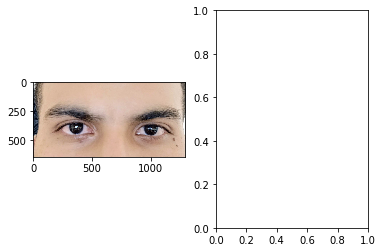

In [65]:
"""Use this to work with images on internet"""

content_URL = 'https://lh3.googleusercontent.com/GYvnhYUP_EOhLSQMAAhT7vaUiIIBEelb3NI--0WIm_vJX5S7OFJNBL2UeoS105hLU9gnH6EWXT1Fej8BNmXBmMaKkDIfwjR-qJ6KMQLehhIDm0HlKudvo7b0QLU8ukh7C8eSls2j8ZBkpAsw7-ccvsutAb5ozoyDobLDpx_b2lvrkWBB7iHWsQvoAlig5k0vIaCfwKJaz_PoACJQ9AlpadXGdy0cIBrBSCqtS8qy98T8PlrhrfKKZw3N5Jk8iCmXtK7uekNdN2D5yFPBcceHkZEbHeZ8JQxZlWs7SN-yo1TPDBi_pl_GaW-ajPokhoqquemunKTob3ljkw7Epfkm0agD1knPApihUW0vBiV6XVWpFaFcbDhMYOIwmz8cEYsGpIxLR7iGDDWu-OLwCZ-Nvlk2GYjJh8GPvlCb-TVCGB5b74HFcpa684W0jhoT99oMW-RXhHKnFdLTHsyIoYVVjra8_xBDiFBVmPV1FMXRHkOan4qvlespcREkgQ4_LvT5MzpU4DLdTYJ49Q2Qthl1d4oAiopwc3_7TYgOiETc4dq8y2UEirh6cYmIFTaMabAE-c3OPKVYZvO9NfJsGKOuKf8gmlJFKFHH3tw1KNeAYNslI1jAtiN0uM5ntt-N0oGpYRi0J4egtZkeEQeIM75RXbjo1TeTEbHu=w1296-h637-no'
#style_URL = 'https://mott.pe/noticias/wp-content/uploads/2016/03/El-singular-forma-de-pintar-con-los-dedos-que-una-artista-descubri%C3%B3-por-accidente-13.jpg'
#content_image, style_image, style_images = readImageFromURL(content_URL, style_URL)
content_image = readImageFromURL(content_URL, width=647, height=318)

In [66]:
print(content_image.shape)

(1, 318, 647, 3)


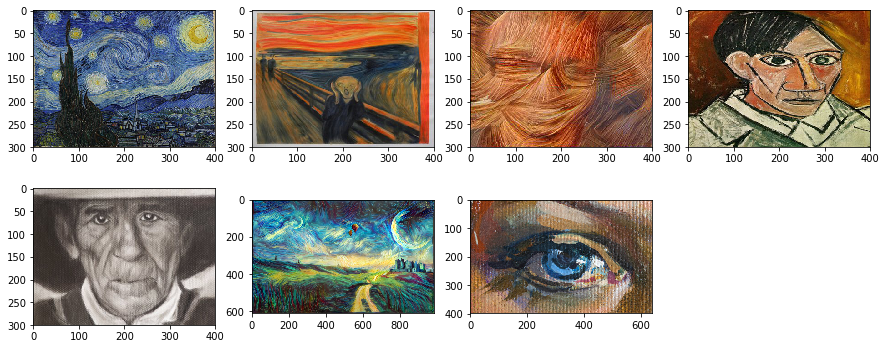

In [70]:
"""Read and show some style images stored in the repo"""

style_image_1 = imageio.imread("/content/nst_Arting/style_images/style_1.jpg")
style_image_2 = imageio.imread("/content/nst_Arting/style_images/style_2.jpg")
style_image_3 = imageio.imread("/content/nst_Arting/style_images/style_3.jpg")
style_image_4 = imageio.imread("/content/nst_Arting/style_images/style_4.jpg")
style_image_5 = imageio.imread("/content/nst_Arting/style_images/style_5.jpg")
style_image_6 = imageio.imread("/content/nst_Arting/style_images/style_6.jpg")
style_image_7 = imageio.imread("/content/nst_Arting/style_images/style_7.jpg")

fig = plt.figure(figsize=(15,6))

ax1 = fig.add_subplot(241)
ax2 = fig.add_subplot(242)
ax3 = fig.add_subplot(243)
ax4 = fig.add_subplot(244)
ax5 = fig.add_subplot(245)
ax6 = fig.add_subplot(246)
ax7 = fig.add_subplot(247)

ax1.imshow(style_image_1);
ax2.imshow(style_image_2);
ax3.imshow(style_image_3);
ax4.imshow(style_image_4);
ax5.imshow(style_image_5);
ax6.imshow(style_image_6);
ax7.imshow(style_image_7);



In [0]:
# resize images to meet the content_image size
style_image_1 = np.array(Image.fromarray(style_image_1).resize((CONFIG.IMAGE_WIDTH, CONFIG.IMAGE_HEIGHT)))
style_image_2 = np.array(Image.fromarray(style_image_2).resize((CONFIG.IMAGE_WIDTH, CONFIG.IMAGE_HEIGHT)))
style_image_3 = np.array(Image.fromarray(style_image_3).resize((CONFIG.IMAGE_WIDTH, CONFIG.IMAGE_HEIGHT)))
style_image_4 = np.array(Image.fromarray(style_image_4).resize((CONFIG.IMAGE_WIDTH, CONFIG.IMAGE_HEIGHT)))
style_image_5 = np.array(Image.fromarray(style_image_5).resize((CONFIG.IMAGE_WIDTH, CONFIG.IMAGE_HEIGHT)))
style_image_6 = np.array(Image.fromarray(style_image_6).resize((CONFIG.IMAGE_WIDTH, CONFIG.IMAGE_HEIGHT)))
style_image_7 = np.array(Image.fromarray(style_image_7).resize((CONFIG.IMAGE_WIDTH, CONFIG.IMAGE_HEIGHT)))

# Preprocess images to feed to the model
style_image_1 = reshape_and_normalize_image(style_image_1)
style_image_2 = reshape_and_normalize_image(style_image_2)
style_image_3 = reshape_and_normalize_image(style_image_3)
style_image_4 = reshape_and_normalize_image(style_image_4)
style_image_5 = reshape_and_normalize_image(style_image_5)
style_image_6 = reshape_and_normalize_image(style_image_6)
style_image_7 = reshape_and_normalize_image(style_image_7)



In [0]:
"""Uncomment corresponding line to use the desired style, uncomment more than one if you want
to mix styles, also can set the weight for each style"""
style_images = []
#style_images.append((style_image_1, 0.2))
#style_images.append((style_image_2, 1))
#style_images.append((style_image_3, 1))
#style_images.append((style_image_4, 0.3))
#style_images.append((style_image_5, 1))
#style_images.append((style_image_6, 1))
style_images.append((style_image_7, 1))

In [0]:
"""Set what layer of the model to use for the style transfer, each layer captures different features
of the image, can also set the weight for each layer"""
STYLE_LAYERS = [
    ('conv1_1', .9), 
    ('conv1_2', .9),
    ('conv2_1', .9),
    ('conv2_2', .9),
    ('conv3_1', .9),
    ('conv3_2', .9),
    ('conv4_1', .9),
    ('conv4_2', .9),
    ('conv4_3', .9),
    ('conv4_4', .9),
    ('conv5_1', .9),
#    ('conv5_2', .5),
#    ('conv5_3', .5),
#    ('conv5_4', .5)
]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 318, 647, 3) (1, 318, 647, 3) (1, 318, 647, 3)


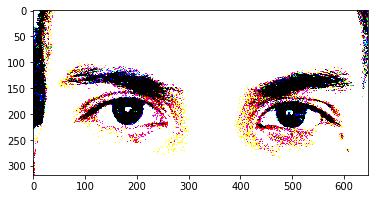

In [76]:
# generate noise image with resemblance to the the content image for faster convergence
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])
print(content_image.shape, style_images[0][0].shape, generated_image.shape)

In [0]:
model = load_vgg_model("imagenet-vgg-verydeep-19.mat")

In [0]:
# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)


J_S = 0
for image in style_images:
  sess.run(model['input'].assign(image[0]))
  J_style = compute_style_cost(model, STYLE_LAYERS)
  J_S += image[1]*J_style

# Total cost
J = total_cost(J_content, J_S)

# define optimizer (1 line)
optimizer = tf.train.AdamOptimizer(2.0)

# define train_step (1 line)
train_step = optimizer.minimize(J)

In [0]:
def model_nn(sess, input_image, num_iterations = 1000):
    
    # Initialize global variables (you need to run the session on the initializer)
    sess.run(tf.global_variables_initializer())
    
    # Run the noisy input image (initial generated image) through the model. Use assign().
    generated_image = sess.run(model['input'].assign(input_image))
    
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
        sess.run(train_step)
        
        # Compute the generated image by running the session on the current model['input']
        generated_image = sess.run(model['input'])

        # Print every 20 iteration.
        if i%50 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_S])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            save_image("output/" + str(i) + ".png", generated_image)
    
    # save last generated image
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

In [82]:
model_nn(sess, generated_image)


Iteration 0 :
total cost = 18656070000.0
content cost = 6634.7603
style cost = 466400100.0
Iteration 50 :
total cost = 683890500.0
content cost = 14274.576
style cost = 17093694.0
Iteration 100 :
total cost = 368119230.0
content cost = 14295.452
style cost = 9199407.0
Iteration 150 :
total cost = 254318700.0
content cost = 14333.324
style cost = 6354384.5
Iteration 200 :
total cost = 193604270.0
content cost = 14418.223
style cost = 4836502.5
Iteration 250 :
total cost = 155265620.0
content cost = 14510.054
style cost = 3878013.0
Iteration 300 :
total cost = 128245190.0
content cost = 14596.039
style cost = 3202480.8
Iteration 350 :
total cost = 107603040.0
content cost = 14668.217
style cost = 2686409.0
Iteration 400 :
total cost = 91125110.0
content cost = 14736.913
style cost = 2274443.5
Iteration 450 :
total cost = 77603200.0
content cost = 14801.176
style cost = 1936379.9
Iteration 500 :
total cost = 66375496.0
content cost = 14859.067
style cost = 1655672.6
Iteration 550 :
total 

array([[[[  41.133724 ,   66.09535  ,   78.00731  ],
         [ -24.611568 ,   36.493164 ,   57.417698 ],
         [  36.000023 ,   30.54775  ,   63.0128   ],
         ...,
         [ -45.788086 , -258.38913  ,  -78.44427  ],
         [-100.600716 , -200.06393  , -209.83539  ],
         [ -69.64562  , -370.83612  , -110.78915  ]],

        [[  23.268318 ,   48.297035 ,   58.616947 ],
         [  31.399698 ,   34.228394 ,   44.376648 ],
         [  49.879223 ,   44.258778 ,   41.7164   ],
         ...,
         [-113.53697  ,  -90.89449  , -225.65219  ],
         [-172.50616  ,  -69.88077  , -147.97276  ],
         [ -82.67769  , -307.18732  ,  -60.44357  ]],

        [[  32.809532 ,   48.298306 ,   79.51357  ],
         [  37.50401  ,   34.76514  ,   40.943726 ],
         [  50.08539  ,   41.66068  ,   51.885437 ],
         ...,
         [ -86.59279  ,  -93.354225 , -186.65807  ],
         [-106.97925  ,  -70.26067  , -196.52301  ],
         [-118.255066 , -267.38055  ,  -22.772884 ]],

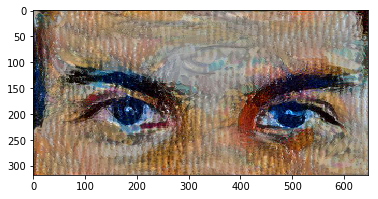

In [83]:
generated = imageio.imread('output/generated_image.jpg')
imshow(generated)

In [0]:
gen_im = Image.open('/content/output/generated_image.jpg')

In [0]:
import cv2
img = cv2.imread('/content/output/generated_image.jpg')
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
img_median = cv2.bilateralFilter(img, 9, 25,25)
#kernel = np.array([[-2,-2,-2], [-2,18,-2], [-2,-2,-2]])
#img_sharp = cv2.filter2D(img_median, -1, kernel)
image = cv2.cvtColor(img_median, cv2.COLOR_BGR2RGB)
cv2.imwrite('cascade_median_5.jpg',image)

In [0]:
files.download('output/generated_image.jpg')


In [0]:
STYLE_LAYERS = [
    ('conv1_1', .4), 
#    ('conv1_2', 0.1),
    ('conv2_1', .4),
#    ('conv2_2', 0.1),
#    ('conv3_1', 1.1),
#    ('conv3_2', 0.1),
    ('conv4_1', .4),
    ('conv4_2', .4),
    ('conv4_3', .2),
    ('conv4_4', .1),
    ('conv5_1', .1),
#    ('conv5_2', 0.1),
#    ('conv5_3', 0.1),
#    ('conv5_4', 0.1)
]

generated_image = generate_noise_image(content_image)


### Miscelaneos

#### Run all styles

This code applies the transfer style one model layer at the time, showing how each layer affects the output image

In [0]:
STYLE_LAYERS = [ ('conv1_1', 1), ('conv1_2', 1), ('conv2_1', 1), ('conv2_2', 1), ('conv3_1', 1), ('conv3_2', 1), ('conv4_1', 1), ('conv4_2', 1), ('conv4_3', 1), ('conv4_4', 1), ('conv5_1', 1), ('conv5_2', 1), ('conv5_3', 1), ('conv5_4', 1) ]
for style in STYLE_LAYERS:
    # Assign the content image to be the input of the VGG model.
    sess.run(model['input'].assign(content_image))

    # Select the output tensor of layer conv4_2
    out = model['conv4_2']

    # Set a_C to be the hidden layer activation from the layer we have selected
    a_C = sess.run(out)

    # Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2']
    # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
    # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
    a_G = out

    # Compute the content cost
    J_content = compute_content_cost(a_C, a_G)


    J_S = 0
    for image in style_images:
        sess.run(model['input'].assign(image[0]))
        J_style = compute_style_cost(model, [style])
        J_S += image[1]*J_style

    # Total cost
    J = total_cost(J_content, J_S)

    # define optimizer (1 line)
    optimizer = tf.train.AdamOptimizer(2.0)

    # define train_step (1 line)
    train_step = optimizer.minimize(J)
    
    generated_image = generate_noise_image(content_image)
    

    model_nn(sess, generated_image)

In [0]:
files.download('output/generated_image_inferno_conv1_1.jpg')
files.download('output/generated_image_inferno_conv1_2.jpg')
files.download('output/generated_image_inferno_conv2_1.jpg')
files.download('output/generated_image_inferno_conv2_2.jpg')
files.download('output/generated_image_inferno_conv3_1.jpg')
files.download('output/generated_image_inferno_conv3_2.jpg')
files.download('output/generated_image_inferno_conv4_1.jpg')
files.download('output/generated_image_inferno_conv4_2.jpg')
files.download('output/generated_image_inferno_conv4_3.jpg')
files.download('output/generated_image_inferno_conv4_4.jpg')
files.download('output/generated_image_inferno_conv5_1.jpg')
files.download('output/generated_image_inferno_conv5_2.jpg')
files.download('output/generated_image_inferno_conv5_3.jpg')
files.download('output/generated_image_inferno_conv5_4.jpg')

#### visualize CNN outputs

This code show you want each filter of each layer in the model is looking at when processing the style image.

In [0]:
sess.run(model['input'].assign(style_image_6))
layer_outputs = ['conv1_1', 'conv1_2', 'conv2_1', 'conv2_2', 'conv3_1', 'conv3_2', 'conv4_1', 'conv4_2', 'conv4_3', 'conv4_4', 'conv5_1', 'conv5_2', 'conv5_3', 'conv5_4']
x = len(layer_outputs)
y = 30
f, axarr = plt.subplots(x,y, figsize=(120,42))
#f.figure(figsize=(10,10))
for i,layer in enumerate(layer_outputs):
  out = model[layer]
  im = sess.run(out)
  for j in range(0,y):
    axarr[i,j].imshow(im[0,:,:,j])
    axarr[i,j].grid(False)
    axarr[i,j].set_ylabel(layer)

#### GPU

Verify that the GPU is working.




In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [0]:
!pip install wurlitzer
# Creates a graph.
#a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
#b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
#c = tf.matmul(a, b)

tf.logging.set_verbosity(tf.logging.INFO)
# Creates a session with log_device_placement set to True.
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Runs the op.
#from wurlitzer import pipes

with pipes() as (out, err):
  with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    print(sess.run(c))

print (out.read())
